平均二乗誤差:32464.680365350523
決定係数:0.9890598706014998


<AxesSubplot:>

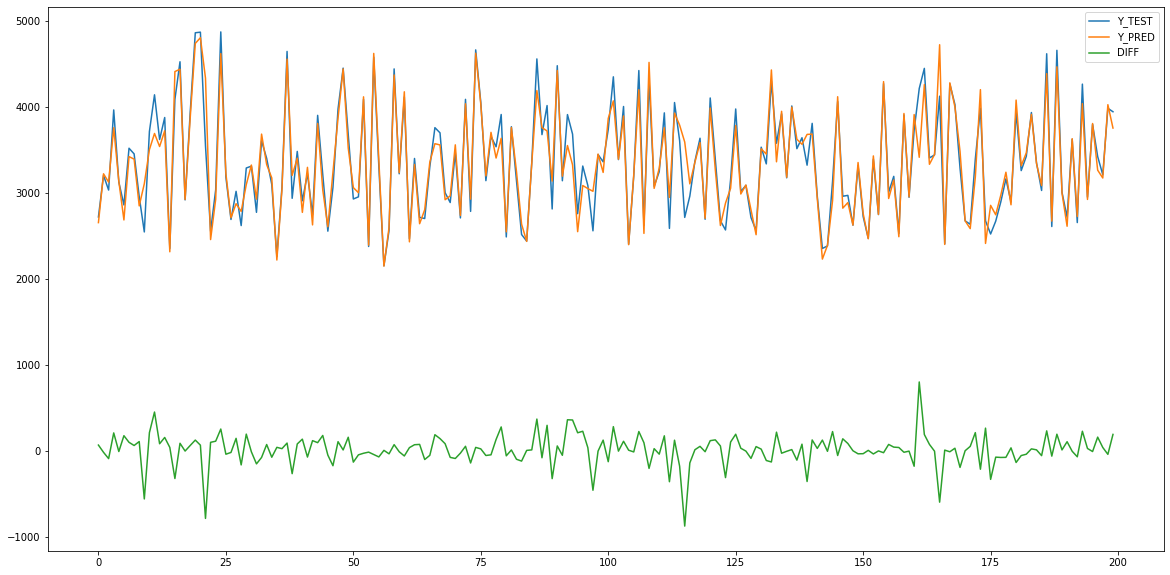

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 対象年の東京の電力需要と平均気温のCSVを読み込む
target_year = 2018
kw_path = "data/electric_juyo_{}.csv".format(target_year)
temp_path = "data/avg_temp_{}.csv".format(target_year)

# それぞれに適切なカラム名を付ける
df_kw = pd.read_csv(kw_path, names=("DATE", "TIME", "KW"))
df_temp = pd.read_csv(temp_path, names=("DATETIME", "TEMP"))

# それぞれの日付データを月・週・日・時にパースする
for i, row in df_temp.iterrows():
    dt = datetime.strptime(row["DATETIME"], "%Y/%m/%d %H:%M")
    df_temp.at[i, "MONTH"] = dt.month
    df_temp.at[i, "WEEK"] = dt.weekday()
    df_temp.at[i, "DAY"] = dt.day
    df_temp.at[i, "HOUR"] = dt.hour

for i, row in df_kw.iterrows():
    date = datetime.strptime(row["DATE"], "%Y/%m/%d")
    time = datetime.strptime(row["TIME"], "%H:%M")
    df_kw.at[i, "MONTH"] = date.month
    df_kw.at[i, "WEEK"] = date.weekday()
    df_kw.at[i, "DAY"] = date.day
    df_kw.at[i, "HOUR"] = time.hour

# 月・週・日・時で平均気温をマージして欠損値行を削除
df = pd.merge(df_kw, df_temp).dropna()

# 説明変数xと目的変数yの配列に変換する
x = df[["MONTH", "WEEK", "HOUR", "TEMP"]].values
y = df[["KW"]].values.flatten()

# 訓練データ:テストデータ＝9:1の割合で訓練データとテストデータを作成する
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 訓練データを元にそれぞれ標準化する
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# ランダムフォレストで学習させる
model = RandomForestRegressor()
model.fit(x_train, y_train)

# 予測する
y_pred = model.predict(x_test)

# 評価データと予測データを比較したときの精度
print("平均二乗誤差:{}".format(mean_squared_error(y_test, y_pred)))
print("決定係数:{}".format(model.score(x_train, y_train)))

# 評価データと予測データを差分をプロット
df_pred = pd.DataFrame({
    "Y_TEST": np.array(y_test),
    "Y_PRED": np.array(y_pred)
})
df_pred["DIFF"] = df_pred["Y_TEST"] - df_pred["Y_PRED"]
df_pred.head(200).plot(figsize=(20, 10))